# **1.** **Goole Drive連携**

In [ ]:
from google.colab import auth,drive,files,output
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -d /content/ '/content/drive/MyDrive/grad-research/archive.zip'

Archive:  /content/drive/MyDrive/grad-research/archive.zip
   creating: /content/archive/Racist/
   creating: /content/archive/Racist/Test/
   creating: /content/archive/Racist/Test/BLACK/
  inflating: /content/archive/Racist/Test/BLACK/100.JPG  
  inflating: /content/archive/Racist/Test/BLACK/101.JPG  
  inflating: /content/archive/Racist/Test/BLACK/103.JPG  
  inflating: /content/archive/Racist/Test/BLACK/104.JPG  
  inflating: /content/archive/Racist/Test/BLACK/105.JPG  
  inflating: /content/archive/Racist/Test/BLACK/110.JPG  
  inflating: /content/archive/Racist/Test/BLACK/118.JPG  
  inflating: /content/archive/Racist/Test/BLACK/17.JPG  
  inflating: /content/archive/Racist/Test/BLACK/18.JPG  
  inflating: /content/archive/Racist/Test/BLACK/22.JPG  
  inflating: /content/archive/Racist/Test/BLACK/44.JPG  
  inflating: /content/archive/Racist/Test/BLACK/46.JPG  
  inflating: /content/archive/Racist/Test/BLACK/51.JPG  
  inflating: /content/archive/Racist/Test/BLACK/57.JPG  
  infl

# **2.** **各種インポート**

In [ ]:
!pip install -U retinaface_pytorch  #RetinaFaceのインストール

     |████████████████████████████████| 9.1 MB 6.8 MB/s 
     |████████████████████████████████| 64 kB 3.1 MB/s 
     |████████████████████████████████| 631 kB 37.8 MB/s 
     |████████████████████████████████| 2.1 MB 31.5 MB/s 
     |████████████████████████████████| 180 kB 42.4 MB/s 
     |████████████████████████████████| 178 kB 46.1 MB/s 
     |████████████████████████████████| 4.3 MB 39.2 MB/s 
     |████████████████████████████████| 76 kB 4.8 MB/s 
     |████████████████████████████████| 111 kB 39.4 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 126 kB 46.8 MB/s 
     |████████████████████████████████| 791 kB 30.7 MB/s 
     |████████████████████████████████| 374 kB 35.2 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654020 sha256=29bc6fe30aa5e09b8694bdc509a1c58b007cc79307c16b2bf8bc2c805db178d2
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e

In [ ]:
import numpy as np

import matplotlib.pyplot as plt #グラフ表示など用ライブラリ
from matplotlib.ticker import MaxNLocator #軸の表示設定用
# ノートブックでmatplotを使う時にはinline指定をした方が良い
%matplotlib inline

from pathlib import Path # pathの扱いが便利になるライブラリ

from tqdm.notebook import tqdm # プログレスバー表示用

import torch #PyTorch
import torch.nn as nn #PyTorchのニューラルネットワークに関するもの
import torch.optim as optim #最適化関数利用のため
import torch.nn.functional as F

import torchvision # PyTorchの画像に関するものをまとめたもの
from torchvision import transforms #データセットの画像加工用
from torchvision.datasets import ImageFolder #ImageFolderクラス利用のため

#---------------RetinaFaceインポート-------------------------------------
from retinaface.pre_trained_models import get_model
from retinaface.utils import vis_annotations



















































## **各種設定**

In [ ]:
#@title #Hyper Parameters
n_epochs =  20#@param {type:"integer"}
batchsize =  32#@param {type:"integer"}
learning_rate = 0.01 #@param {type:"raw"}

In [ ]:
#@title #Input/Output
#@markdown ### trainデータセットのパス:
TRAIN_DATA_PATH = "/content/archive/Racist/Train"#@param{type:"string"}
#@markdown ### testデータセットのパス:
TEST_DATA_PATH = "/content/archive/Racist/Test"#@param{type:"string"}
#@markdown ---

#@markdown ### 1エポックごとに何回ログをprintするか:
PRINT_COUNT_PER_EPOCH =  5 #@param{type:"integer"}

#@markdown ### 出力結果を保存する基本的なパス:
BASE_OUT_PATH = '/content/drive/MyDrive/grad-research/' #@param{type:"string"}

#@markdown ### 学習したモデルを保存する名前:
MODEL_OUT_NAME = 'retinaface_resnet50_2020-07-20-f168fae3c.pth' #@param{type:"string"}


In [ ]:
#データセットの画像加工用 Transform を作成
transform = {
    'Train':transforms.Compose(
    [transforms.Resize((128,128)), # 画像サイズを一定にする
     transforms.ToTensor()  # NNで計算しやすい様に画像を変換
     ]),
     'Test':transforms.Compose(
    [transforms.Resize((128,128)), # 画像サイズを一定にする
     transforms.ToTensor()  # NNで計算しやすい様に画像を変換
     ])
}

# Dataset を作成
train_dataset = ImageFolder(TRAIN_DATA_PATH, transform['Train'])
print("train dataset:\n",train_dataset,"\n")

datapoints = len(train_dataset)

print("train dateset length:\n",datapoints,"\n")
print("train dataset class to idx:\n",train_dataset.class_to_idx,"\n")

# Dataloader を作成
# 学習データはエポックごとに各バッチの傾向が変わる（学習の傾向が変わる）ようにshuffleする
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batchsize,
                                          shuffle=True, num_workers = 0)
print("train loader:\n",trainloader,"\n")

# classラベルをデータセットから読み取る
classes = [key for key in  train_dataset.class_to_idx]
print("classes:\n",classes,"\n") 

#gpuが使える場合はgpu、そうでない場合はcpuをデバイスに指定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("use device:",device)

train dataset:
 Dataset ImageFolder
    Number of datapoints: 1651
    Root location: /content/archive/Racist/Train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           ) 

train dateset length:
 1651 

train dataset class to idx:
 {'BLACK': 0, 'WHITE': 1, 'YELLOW': 2} 

train loader:

classes:
 ['BLACK', 'WHITE', 'YELLOW'] 

use device: cuda:0


# **3.** **学習モデルの定義**

In [ ]:
# nn.Moduleを継承することが重要

class MyModel(nn.Module):

  def __init__(self, n_classes=None):
    super(MyModel, self).__init__() #親クラスのコンストラクタを実行しておく
    
    '''実際に利用する層などをinitスコープで定義する'''
    # 畳込み層：convolution層なのでconvと略されることが多い
    # conv1は画像データが入力される最初のconvolution層なので
    # in_channelsは3
    # 他の値は全てハイパーパラメータ
    self.conv1 = nn.Conv2d(3, 32, 5)
    self.conv2 = nn.Conv2d(32, 48, 5)

    # プーリング：poolingのパラメータは学習するものではないので再利用可能
    self.pool = nn.MaxPool2d(2, 2)
    
    # 全結合：fully connected なのでfcと略されることが多い
    # `self.fc3`のout_featuresは分類クラス数に応じて変更する必要がある -済
    self.fc1 = nn.Linear(48 * 29 * 29 , 120) #各自変更が必要
    self.fc2 = nn.Linear(120, 84) 
    self.fc3 = nn.Linear(84, 3)          #各自変更が必要 -済

  def forward(self, x):
    '''順伝播での計算を記述'''
    # conv -> relu -> poolを一個ずつ書く方法
    h = self.conv1(x)
    h = F.relu(h)
    h = self.pool(h)

    # conv -> relu -> poolをまとめて書く方法
    h = self.pool(F.relu( self.conv2(h)) )
    
    #print(h.shape) [batch_size, 16, 5, 5]
    
    # 全結合層に入れる前に1次元化   
    # 以下のviewとflattenは同じことをしている
    # viewの方はベクトルに整形する際、ベクトルのサイズを16*5*5と指定すれば
    # もう一方（バッチサイズ）は自動的にプログラムが分かる為、-1としておけば自動的に必要な数をいれてくれる
    #h = h.view(-1, 16 * 5 * 5)
    
    # flattenは全結合層に入れる前に(バッチ数, 1次元ベクトル)という形状に変形したいという需要に対してとても便利
    # 細かな値を指定しなくても以下で希望の形になる
    # ただし、`self.fc1`のin_featuresの値を決めるためにはどちらにせよベクトルの要素数を知らなければいけない
    # 計算が面倒な場合はflattenして出てきたものの形状をprintしてみれば必要な要素数がわかるので便利
    h = torch.flatten(h, start_dim=1)
    
    print(h.shape)
    # ->
    # これを実行すると学習ループ内に
    # torch.Size([64, 400])
    # などと表示されるので`self.fc1`のin_featuresを400にすればよいとわかる
    # (64の部分は指定したバッチサイズによって変化)

    # fc -> reluを一個ずつ書く方法
    h = self.fc1(h)
    h = F.relu(h)
    # fc -> reluをまとめて書く方法
    h = F.relu(self.fc2(h))

    output = self.fc3(h)    
    return output

# **4.** **学習ループ**

In [ ]:
#インスタンス生成
model = MyModel()
print("model:\n",model,"\n")
# 学習モードに切り替える
model.train()
# モデルをdeviceに送る。CPUで動かしたい時はやらなくても良い。
model.to(device) 
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9) #最適化関数
print("optimizer:\n",optimizer,"\n")

criterion = nn.CrossEntropyLoss() #損失関数
print("criterion:\n",criterion,"\n")

# 各エポックで最後にprintした値をグラフ表示用に格納しておくためのもの
results_train = {'loss': [],'accuracy': []}

# 1エポックごとの反復回数（iteration）
iteration = datapoints / batchsize
# 何iterationごとにprintするか
print_iteration = iteration // PRINT_COUNT_PER_EPOCH

print('[epoch, iteration]')

# training loop
for epoch in range(n_epochs):
  #list for loss and accuracy

  running_loss = 0.0
  running_accuracy = 0.0
  
  # 新規エポックごとにリストに要素追加
  results_train['loss'].append(running_loss)
  results_train['accuracy'].append(running_accuracy)

  for i, data in enumerate(trainloader, 0):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    # forwardを実行
    # 特殊なメソッドなのでmodel.forward()のように書かなくてもmodel()で実行されるようになっている
    outputs = model(images)

    optimizer.zero_grad()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # calculate print loss and accuracy
    # lossの加算
    running_loss += loss.item()

    # outputsの各バッチで何番目のクラスの確率が最大かをpredictedに格納
    _, predicted = torch.max(outputs.data, 1)
    # predictedとlabelsが一致する個数が予測に正解している数correct
    correct = (predicted == labels).sum()
    # batchsizeで割ることで精度にし、%にする
    accuracy = 100 * correct / batchsize
    # accuracyの加算
    running_accuracy += accuracy.item()
    # print_iterationごとのprint
    if i % print_iteration == print_iteration - 1:
        # 加算したlossとaccuracyを反復数で割る
        # 一番最後のprintした値で常に上書きすれば、各epohで最後にprintした値が取得できる
        results_train['loss'][epoch] = running_loss / print_iteration
        results_train['accuracy'][epoch] = running_accuracy / print_iteration
        
        print('[%5d, %9d]  loss: %.3f,  accuracy: %.3f' %
              (epoch + 1, i + 1, results_train['loss'][epoch],results_train['accuracy'][epoch] ))
        
        # print iteration毎に変数初期化
        running_loss = 0.0
        running_accuracy = 0.0

#モデルの保存
torch.save(model.state_dict(), BASE_OUT_PATH + MODEL_OUT_NAME)


model:
 MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=40368, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
) 

optimizer:
 SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
) 

criterion:
 CrossEntropyLoss() 

[epoch, iteration]
torch.Size([32, 40368])
torch.Size([32, 40368])
torch.Size([32, 40368])
torch.Size([32, 40368])
torch.Size([32, 40368])
torch.Size([32, 40368])
torch.Size([32, 40368])
torch.Size([32, 40368])
torch.Size([32, 40368])
torch.Size([32, 40368])
[    1,        10]  loss: 1.089,  accuracy: 36.562
torch.Size([32, 40368])
torch.Size([32, 40368])
torch.Size([32, 40368])
torch.Size([32, 40368])
torch.Size([32, 40368]

# **5.** **結果の表示**

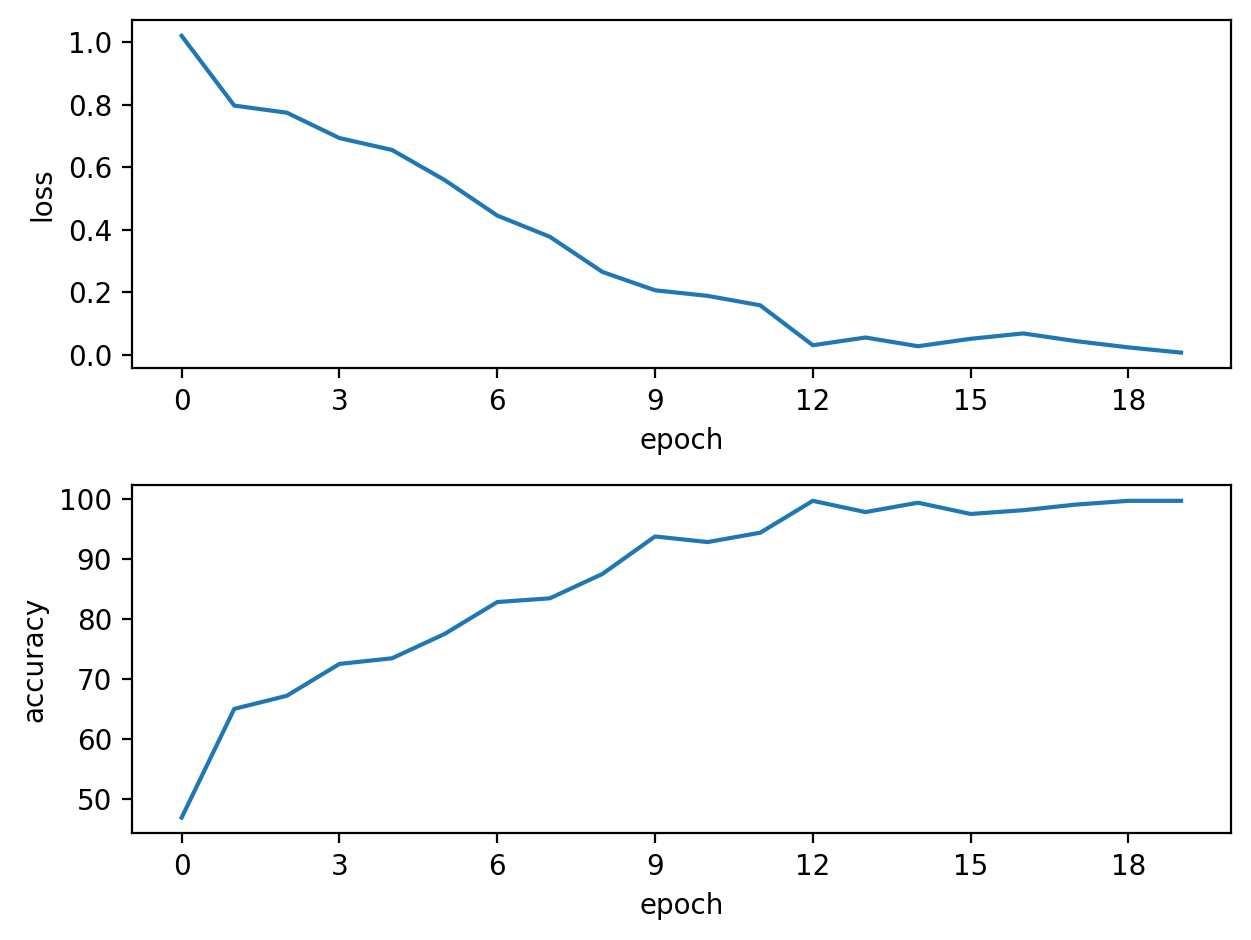

In [ ]:
# 台紙を作成
# facecolorはグラフ全体の背景色を設定
# dpiで解像度が変わる
fig = plt.figure(figsize=(6.4, 4.8), dpi=200, facecolor='w')

# 上下に2つのグラフを用意
# ylim=(0, 100)のように引数を指定すれば表示範囲が0～100になる
# 見やすい範囲については各自で考える
axT = fig.add_subplot(211,xlabel='epoch',ylabel='loss')#2行1列の1番目
axB = fig.add_subplot(212,xlabel='epoch',ylabel='accuracy')#2行1列の2番目

# x軸の要素は、今回epochなので指定しなくても良いが念のため
epochs = range(n_epochs)

# epochは整数なので整数表示のためのオプション
# この行を実行しないとx軸が実数表示になるはず
axT.xaxis.set_major_locator(MaxNLocator(integer=True))
axB.xaxis.set_major_locator(MaxNLocator(integer=True))

# プロット
axT.plot(epochs, results_train['loss'])
axB.plot(epochs, results_train['accuracy'])

# 軸ラベルと図が被ることを防止
fig.tight_layout()
# 画像として保存
fig.savefig(BASE_OUT_PATH + 'loss_acc.png', facecolor=fig.get_facecolor())

# **6.** **学習モデル読込、テストローダー作成**

In [ ]:
#@markdown ### テストに使用する学習済みモデルを読み込むパス:
MODEL_LOAD_PATH =  '/content/drive/My Drive/grad-research/retinaface_resnet50_2020-07-20-f168fae3c.pth' #@param{type:"string"}

────────────────────────────────────────

In [ ]:
test_dataset = ImageFolder(TEST_DATA_PATH, transform['Test'])
print("test dataset class to idx:\n",test_dataset.class_to_idx,"\n")
test_samples = len(test_dataset)
print("test samples:\n",test_samples,"\n")

# classラベルをデータセットから読み取る
classes = [key for key in  test_dataset.class_to_idx]
print("classes:\n",classes,"\n") 

test_batchsize = 5
# テストデータは全部のデータに同じことをするだけなので普通はsuffleしない
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batchsize,
                                         shuffle=False, num_workers = 2)
print("test loader:\n",testloader,"\n")

test dataset class to idx:
 {'BLACK': 0, 'WHITE': 1, 'YELLOW': 2} 

test samples:
 74 

classes:
 ['BLACK', 'WHITE', 'YELLOW'] 

test loader:



# **7.** **テスト用データセットに対する精度検証**

In [ ]:
#gpuが使える場合はgpu、そうでない場合はcpuをデバイスに指定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("use device:",device,"\n")

#インスタンス生成
model = MyModel() 
print("model:\n",model,"\n")

# 重みパラメータ読み込み
model.load_state_dict(torch.load(MODEL_LOAD_PATH))

# testモードに切り替える
model.eval()

model.to(device) 

correct = 0
for data in tqdm(testloader):
  images, labels = data
  images = images.to(device)
  labels = labels.to(device)

  # 勾配計算しない状態で動かす
  with torch.no_grad():
    outputs = model(images)
    # outputsの各バッチで何番目のクラスの確率が最大かをpredictedに格納
    _, predicted = torch.max(outputs.data, 1)
    # predictedとlabelsが一致する個数が予測に正解している数correct
    correct += (predicted == labels).sum().item()

# test画像のサイズで割ることで精度にし、%にする
accuracy = 100 * correct / test_samples

print("test accuracy:",accuracy)

use device: cuda:0 

model:
 MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=40368, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
) 



  0%|          | 0/15 [00:00<?, ?it/s]

torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([4, 40368])
test accuracy: 55.4054054054054


# **8.** **テスト用データセットに対する分類結果の確認**

In [ ]:
#gpuが使える場合はgpu、そうでない場合はcpuをデバイスに指定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("use device:",device,"\n")

#インスタンス生成
model = MyModel() 
print("model:\n",model,"\n")

# 重みパラメータ読み込み
model.load_state_dict(torch.load(MODEL_LOAD_PATH))

# testモードに切り替える
model.eval()

model.to(device) 

# Create result directory
root_path = Path(BASE_OUT_PATH)
save_dir_name = "result"
result_dir = root_path / save_dir_name

cols = test_batchsize # 列数
rows = 6 # 行数

figsize = (6.4,12.8)
dpi = 100

row = 0
fig = plt.figure(figsize=figsize, facecolor="w",dpi=dpi)
fig.tight_layout()

if not result_dir.exists():
  result_dir.mkdir()

for i,data in enumerate(tqdm(testloader)):
  images, labels = data
  images = images.to(device)
  labels = labels.to(device)
  
  # 勾配計算しない状態で動かす
  with torch.no_grad():
    # 予測
    outputs = model(images)

  if row == rows:
    row = 0
    plt.savefig(result_dir / f'{(cols * i)-cols*rows}-{(cols * i)-1}_batches.png')
    #plt.show()
    plt.clf() 
    plt.close(fig)
    fig = plt.figure(figsize=figsize, facecolor="w",dpi=100)
    # 軸ラベルと図が被ることを防止
    fig.tight_layout()
  # outputsの各バッチで何番目のクラスの確率が最大かをpredictedに格納
  _, predicted = torch.max(outputs.data, 1)

  # 各バッチに対して
  for j, index in enumerate(predicted):
    ax = fig.add_subplot(rows, cols, (j + 1) + row * cols)
    ax.imshow(np.asarray(images[j].detach().to('cpu').numpy()).transpose(1,2,0))

    t_label = classes[int(labels[j])]#正解ラベル
    p_label = classes[int(index)]#予測ラベル

    if t_label == p_label:
      ax.set_title(t_label + "\n↓\n" + p_label)
    else:
      ax.set_title(t_label + "\n↓\n" + p_label, color = "red")
    ax.set_axis_off()
  row += 1


plt.savefig(result_dir / f'{test_samples - cols * row}-{test_samples - 1}_batches.png')
#plt.show()
plt.clf() 
plt.close(fig)
print("end")


use device: cuda:0 

model:
 MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=40368, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
) 



  0%|          | 0/15 [00:00<?, ?it/s]

torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([5, 40368])
torch.Size([4, 40368])
end
